# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [80]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

def get_spike_depths(temps, winv, ycoords,spikeTemplates):
    
    ''' 
    Compute spike depths for each cluster

    Params
    ------ 
    temps: the templates (nTemplates x nTimePoints x nChannels)
    winv: the whitening matrix (nCh x nCh)
    ycoords: the coordinates of the channels (nCh x 1)
    spikeTemplates: which template each spike came from (nSpikes x 1)

    Returns
    --------
    spikeDepths is the position along the probe of every spike, (nSpikes x 1)
    according to the position of the template it was extracted with. Distance in microns from tip.

    '''
    #unwhiten all templates
    tempsUnW = np.zeros(shape = (temps.shape[0],temps.shape[1],temps.shape[2]))
    for t in range(0,temps.shape[0]):
        tempsUnW[t,:,:] = np.matmul(temps[t,:,:],winv)

    #get the amplitude on each channel as the max minus min in timepoints (shape nTemp x nCh)
    tempChanAmps = np.max(tempsUnW, axis = 1) - np.min(tempsUnW, axis = 1)

    #the template amplitude is the amplitude of the largest channel 
    tempAmpsUnscaled = np.max(tempChanAmps, axis = 1) #shape nTemp

    #zero out potentially many low values on distant channels; for every channel if below amp 
    threshVals = tempAmpsUnscaled*0.3
    for i in range(0,tempChanAmps.shape[1]):
        for j in range(0,len(threshVals)):
            if tempChanAmps[j,i] < threshVals[j]:
                tempChanAmps[j,i] = 0

    #compute template depth as a center of mass
    templateDepths = np.sum(tempChanAmps*ycoords, axis = 1) / (np.sum(tempChanAmps, axis = 1))

    #each spikes depth is the depth of its template
    spikeDepths = templateDepths[templates]
    
    return spikeDepths

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [84]:
'''Load Session Metadata'''
sessionmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/SessionMetadata.csv')

In [6]:
''' Complete List of Mice & Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [7]:
'''Define which mice & sessions to load'''
mice = all_mice
sessions = all_sessions
    
# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [8]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [9]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Classify positively and negatively speed-tuned (+ / - speed) cells 

In [ ]:
''' Calculate & Save Real Speed Scores & Speed Stability Scores '''
realspeedscores = []
realspeedstabscores = []
dt = 0.02
sigma = 20  # smoothing factor for instantaneous firing rate
n_bin = 8 #n position bins considered for speed stability score
track_length = 400 #cm
bins = np.arange(0,track_length + (track_length/n_bin),(track_length/n_bin))

#adjust paths as needed
save_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' #wherever you want to save this...
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'#output of import/filter notebook

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(dataload_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(dataload_folder + behavior_file, allow_pickle=False)
        posxfil = behaviorfil[:,0]
        Y = np.load(dataload_folder + spikes_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        speed = behaviorfil[:,1] #already filtered through gaussian (10 timebins) 
        
        # divide all obs into 8 x 50 cm bins
        bin_idx = []
        for i in range(n_bin):
            if i == (n_bin - 1):
                idx = np.where((posxfil >= bins[i]) & (posxfil <= bins[i + 1]))[0]
            else:
                idx = np.where((posxfil >= bins[i]) & (posxfil < bins[i + 1]))[0]
            bin_idx.append(idx)
        
        #get smoothed spike train, calculate speed score
        A = np.zeros((len(speed), len(cell_IDs)))
        realspeed_score = []
        realspeedstab_score = []
        for i, c in enumerate(cell_IDs):
            A[:,i] = Y[:,i]
            A[:,i] = gaussian_filter1d(A[:,i],sigma)
            
            #calculate speed score
            sscore, _ = stats.pearsonr(A[:,i],speed)
            realspeed_score = np.append(realspeed_score,sscore)
            
            #calculate & store speed stability score for this cell's smoothed spike train
            bin_pspikes = []
            for j in range(n_bin):
                idx = bin_idx[j]
                psscore, _ = stats.pearsonr(A[idx,i],speed[idx])
                bin_pspikes = np.append(bin_pspikes, (psscore *  np.sum(A[idx,i])))

            sstabscore = np.sum(bin_pspikes) / np.sum(A[:,i])
            realspeedstab_score = np.append(realspeedstab_score,sstabscore)
            
        d['speedscore'] = realspeed_score
        d['speedstabscore'] = realspeedstab_score
        d['A'] = A

        #Save stuff
        realinstspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'
        
        #np.save(save_folder + realinstspeedscore_file, realspeed_score)
        #print('saved real speed score data as npy file for mouse ' + m + ' session '+ s)
        #np.save(save_folder + realspeedstabscore_file, realspeedstab_score)
        #print('saved real speed stability score data as npy file for mouse ' + m + ' session '+ s)
        #np.save(save_folder + A_file, A)
        #print('saved filtered, binned spikes as npy file for mouse ' + m + ' session '+ s)


In [10]:
'''Load Scores & Save Booleans of Negative & Positively Modulated Speed Cells 
  
 NOTE: shuffled scores are produced by the notebook "Shuffle Procedure." Please run that for all sessions before proceeding here.

'''  
#adjust paths 
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #output of import/filter notebook
save_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' #output location of cell above
scoreload_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/' #output of shuffle / interneuron classification notebook

#if you didn't run the shuffle notebook and instead used the Dryad repo scores, adjust these paths & adjust lines below as well:
#scoreload1_folder = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedscores/'
#scoreload2_folder = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedstabscores/'

P99score = []
P99stabscore = []
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        realspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #Load stuff & get data relevant to classification
        d['speedscore'] = np.load(save_folder + realspeedscore_file)
        d['speedstabscore'] = np.load(save_folder + realspeedstabscore_file)
        d['shufspeedscore'] = np.load(scoreload_folder + shufinstspeedscore_file, allow_pickle = True)
        #d['shufspeedscore'] = np.load(scoreload1_folder + shufinstspeedscore_file, allow_pickle = True) 
        d['shufspeedstabscore'] = np.load(scoreload_folder + shufspeedstabscore_file, allow_pickle = True)
        #d['shufspeedstabscore'] = np.load(scoreload2_folder + shufspeedstabscore_file, allow_pickle = True) 
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        cell_IDs = raw.item().get('cellsfil')
        
        speedcell99 = []
        speedcell1 = []
        
        #Classify excitatory, positively & negatively modulated speed cells
        for i, c in enumerate(cell_IDs):
            dist = abs(shufspeedscore[:,i])
            P99 = np.percentile(dist,99)
            
            dist2 = abs(shufspeedstabscore[:,i])
            sP99 = np.percentile(dist2,99)
            
            P99stabscore = np.append(P99stabscore, sP99)
            P99score = np.append(P99score, P99)

            if (abs(realspeed_score[i]) >= P99) & (abs(realspeedstab_score[i]) >= sP99):
                if realspeed_score[i] >= 0: # pos mod P99 cell
                    speedcell99 = np.append(speedcell99, True)
                    speedcell1 = np.append(speedcell1, False)
                else: # neg mod P99 cell
                    speedcell99 = np.append(speedcell99, False)
                    speedcell1 = np.append(speedcell1, True) 
            else:
                speedcell99 = np.append(speedcell99, False)
                speedcell1 = np.append(speedcell1, False) 

        speedcell99 = np.asarray(speedcell99).astype(bool)
        speedcell1 = np.asarray(speedcell1).astype(bool)
                
        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedcell99'] = speedcell99
        d['speedcell1'] = speedcell1
        
        speedcell99_file = 'speedcell99_' + m + '_' + s + '.npy'
        speedcell1_file = 'speedcell1_' + m + '_' + s + '.npy'
        
        #np.save(save_folder + speedcell99_file, speedcell99)
        #np.save(save_folder + speedcell1_file, speedcell1)
        print('saved all speed cell booleans as npy files for mouse ' + m + ' session '+ s)

saved all speed cell booleans as npy files for mouse A3 session 0122_record1
saved all speed cell booleans as npy files for mouse A3 session 0123_record2
saved all speed cell booleans as npy files for mouse A3 session 0124_record3
saved all speed cell booleans as npy files for mouse A3 session 0125_record4
saved all speed cell booleans as npy files for mouse A3 session 0126_record5
saved all speed cell booleans as npy files for mouse A3 session 0127_record6
saved all speed cell booleans as npy files for mouse A4 session 0122_record1
saved all speed cell booleans as npy files for mouse A4 session 0123_record2
saved all speed cell booleans as npy files for mouse A4 session 0124_record3
saved all speed cell booleans as npy files for mouse A4 session 0125_record4
saved all speed cell booleans as npy files for mouse A4 session 0126_record5
saved all speed cell booleans as npy files for mouse A4 session 0127_record6
saved all speed cell booleans as npy files for mouse A5 session 0401_record1

saved all speed cell booleans as npy files for mouse A18 session 082322_record1real
saved all speed cell booleans as npy files for mouse A18 session 082422_record2
saved all speed cell booleans as npy files for mouse A18 session 082522_record3
saved all speed cell booleans as npy files for mouse A18 session 082622_record4
saved all speed cell booleans as npy files for mouse A18 session 082722_record5
saved all speed cell booleans as npy files for mouse A18 session 082822_record6
saved all speed cell booleans as npy files for mouse MA1F session 102322_record1
saved all speed cell booleans as npy files for mouse MA1F session 102422_record2
saved all speed cell booleans as npy files for mouse MA1F session 102522_record3
saved all speed cell booleans as npy files for mouse MA1F session 102622_record4
saved all speed cell booleans as npy files for mouse MA1F session 102722_record5
saved all speed cell booleans as npy files for mouse MA1F session 102822_record6
saved all speed cell booleans 

saved all speed cell booleans as npy files for mouse A20 session 012823_record3
saved all speed cell booleans as npy files for mouse A20 session 012923_record4
saved all speed cell booleans as npy files for mouse A20 session 013023_record5
saved all speed cell booleans as npy files for mouse A20 session 013123_record6
saved all speed cell booleans as npy files for mouse A22 session 012923_record2
saved all speed cell booleans as npy files for mouse A22 session 013023_record3
saved all speed cell booleans as npy files for mouse A22 session 013123_record4
saved all speed cell booleans as npy files for mouse A22 session 020123_record5
saved all speed cell booleans as npy files for mouse A22 session 020223_record6
saved all speed cell booleans as npy files for mouse A22 session 020323_record7
saved all speed cell booleans as npy files for mouse A23 session 020923_record1
saved all speed cell booleans as npy files for mouse A23 session 021023_record2
saved all speed cell booleans as npy fil

# Examine speed tuning among classified speed cells (Figures 6A-E)

A3 0122_record1 544


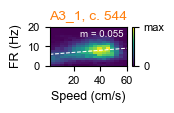

Y18 062222_record3 58


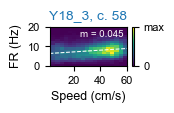

MA1F 102522_record3 965


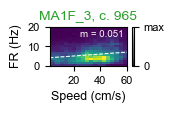

In [43]:
''' Plot Single, Labeled 2D Heat Maps for Representative + Speed Cells (Figure 6A top row panels)'''

save_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' #output location of cell above
scoreload_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/' #output of shuffle procedure 
save_example_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/speedcellexamples/' #wherever you want to save these

ex_mice = ['Y18','MA1F','A3']
ex_sessions = ['062222_record3','102522_record3','0122_record1']
ex_cells = [544, 58, 965]
count = 0
dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in session:
        
        if (m not in ex_mice) or (s not in ex_sessions):
            continue
        
        d = data[m][s]
    
        #get file names & load data necessary
        A_file = 'A_' + m + '_' + s + '.npy'
        A = np.load(save_folder + A_file)
        A = A / dt
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        # ID excitatory speed tuned cells as +/- speed cells
        cell_IDs = raw.item().get('cellsfil')
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        x_bins = np.linspace(0,60,20)
        y_bins = np.linspace(0,20,20)
        
        if m in all_young_mice: 
            col = 'C0'
        elif m in all_aged_mice:
            col = 'C1'
        else:
            col = 'C2'
                
        for i, c in enumerate(speedcells99): #plots three example cells per session
        
            try:  #handles trivial indexing issue for ex_cells list   
                if (c == ex_cells[count]):
                    
                    print(m,s,c)

                    sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                    slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])

                    #plot 2D histogram / heatmap
                    fig, ax = plt.subplots(figsize = (1.25,0.5))

                    h = ax.hist2d(speed, A[:,sdx], bins = [x_bins, y_bins])
                    cbar = fig.colorbar(h[3], ax=ax, ticks = [0,np.max(h[0])])
                    cbar.ax.set_yticklabels(['0','max'])
                    cbar.ax.tick_params(labelsize = 8)

                    ax.set_title(str(m) + '_' + str(s[-1]) + ', c. ' + str(c), fontsize = 10, color = col)
                    ax.text(x = 25, y = 15, s = 'm = ' + str(np.round(slopeFR, 3)), color = 'w', fontsize = 7)
                    ax.tick_params(labelsize = 8)
                    plt.xlabel('Speed (cm/s)', fontsize = 9)
                    plt.ylabel('FR (Hz)', fontsize = 9)

                    #overlay correlation line
                    plt.xlim([2,60])
                    ax.set_xticks([20,40,60])
                    ax.set_yticks([0,10,20])
                    plt.ylim([0,20])
                    X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
                    plt.plot(X_plot, slopeFR*X_plot + intFR, '--', color = 'w', linewidth = 0.75)
                    #plt.savefig(save_example_folder + str(m) + '_' + str(s) + '_' + str(c) + '.png', dpi = 400, bbox_inches = 'tight')
                    #plt.savefig(save_example_folder + str(m) + '_' + str(s) + '_' + str(c) + '.svg', dpi = 400, bbox_inches = 'tight')
                    plt.show()

                    count += 1
            except:
                continue

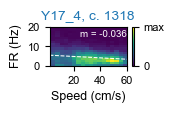

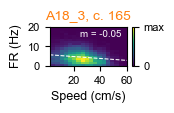

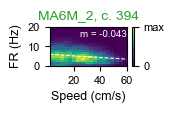

In [45]:
''' Plot Single, Labeled 2D Heat Maps for Representative - Speed Cells (Figure 6A bottom row panels)'''

save_example_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/speedcellexamples/' #wherever you want to save these

ex_mice = ['Y17','MA6M','A18']
ex_sessions = ['070122_record4','103122_record2','082522_record3']
ex_cells = [1318,165,394]
count = 0
dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in session:
        
        if (m not in ex_mice) or (s not in ex_sessions):
            continue
        
        d = data[m][s]
    
        #get file names & load data necessary
        A_file = 'A_' + m + '_' + s + '.npy'
        A = np.load(save_folder + A_file)
        A = A / dt
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        # ID excitatory speed tuned cells as +/- speed cells
        cell_IDs = raw.item().get('cellsfil')
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        x_bins = np.linspace(0,60,20)
        y_bins = np.linspace(0,20,20)

        if m in all_young_mice: 
            col = 'C0'
        elif m in all_aged_mice:
            col = 'C1'
        else:
            col = 'C2'
                
        for i, c in enumerate(speedcells1): #plots three example cells per session
        
            try:  #handles trivial indexing issue for ex_cells list   
                if (c == ex_cells[count]):

                    sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                    slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])

                    #plot 2D histogram / heatmap
                    fig, ax = plt.subplots(figsize = (1.25,0.5))

                    h = ax.hist2d(speed, A[:,sdx], bins = [x_bins, y_bins])
                    cbar = fig.colorbar(h[3], ax=ax, ticks = [0,np.max(h[0])])
                    cbar.ax.set_yticklabels(['0','max'])
                    cbar.ax.tick_params(labelsize = 8)

                    ax.set_title(str(m) + '_' + str(s[-1]) + ', c. ' + str(c), fontsize = 10, color = col)
                    ax.text(x = 25, y = 15, s = 'm = ' + str(np.round(slopeFR, 3)), color = 'w', fontsize = 7)
                    ax.tick_params(labelsize = 8)
                    plt.xlabel('Speed (cm/s)', fontsize = 9)
                    plt.ylabel('FR (Hz)', fontsize = 9)

                    #overlay correlation line
                    plt.xlim([2,60])
                    ax.set_xticks([20,40,60])
                    ax.set_yticks([0,10,20])
                    plt.ylim([0,20])
                    X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
                    plt.plot(X_plot, slopeFR*X_plot + intFR, '--', color = 'w', linewidth = 0.75)
                    #plt.savefig(save_example_folder + str(m) + '_' + str(s) + '_' + str(c) + '.png', dpi = 400, bbox_inches = 'tight')
                    #plt.savefig(save_example_folder + str(m) + '_' + str(s) + '_' + str(c) + '.svg', dpi = 400, bbox_inches = 'tight')
                    plt.show()

                    count += 1
            except:
                continue

In [48]:
''' For positive and negatively modulated, excitatory speed cells, plot distribution of scores vs. shuffle in separate colors '''

posscore = []
posshuffscore = []
posstabscore = []
posshuffstabscore = []
negscore = []
negshuffscore = []
negstabscore = []
negshuffstabscore = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        speedcell99 = d['speedcell99'].astype(bool)
        speedcell1 = d['speedcell1'].astype(bool)
        
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)

        #get cell IDs, filtered behavioral/spike data, & relevant score
        poscells = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        negcells = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        for i, c in enumerate(poscells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffscore = np.random.choice(np.ravel(shufspeedscore[:,sdx]))
            shuffstabscore = np.random.choice(np.ravel(shufspeedstabscore[:,sdx]))
            stabscore = realspeedstab_score[sdx]
            score = realspeed_score[sdx]
            
            posscore = np.append(posscore,score)
            posshuffscore = np.append(posshuffscore,shuffscore)
            posstabscore = np.append(posstabscore,stabscore)
            posshuffstabscore = np.append(posshuffstabscore,shuffstabscore)
            
        for i, c in enumerate(negcells):
            sdx = np.where(cell_IDs == c)[0][0]
            
            shuffscore = np.random.choice(np.ravel(shufspeedscore[:,sdx]))
            shuffstabscore = np.random.choice(np.ravel(shufspeedstabscore[:,sdx]))
            stabscore = realspeedstab_score[sdx]
            score = realspeed_score[sdx]

            negscore = np.append(negscore,score)
            negshuffscore = np.append(negshuffscore,shuffscore)
            negstabscore = np.append(negstabscore,stabscore)
            negshuffstabscore = np.append(negshuffstabscore,shuffstabscore)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


n pos speed cells, neg speed cells: 
11528 6548


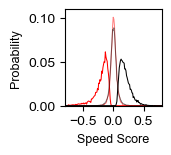


Pos Speed Scores, Real vs. Shuffle Pairs:
mean, SEM + speed cell score:
0.19283799920635647 0.0008566168440621046
mean, SEM shuffle + speed cell stab score:
0.00030751884949412576 0.0005338327101672303
stat = 1797.0
p_cells = 0.0

Neg Speed Scores, Real vs. Shuffle Pairs:
mean, SEM - speed cell score:
-0.2010307096306674 0.0014573509990108288
mean, SEM shuffle - speed cell score:
0.0002179825864153417 0.0006343270241210665
stat = 70.0
p_cells = 0.0

Pos vs. Neg Speed Scores:
stat = -111.92542898749825
p_cells = 0.0


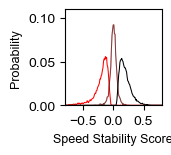


Pos Speed Stability Scores, Real vs. Shuffle Pairs:
mean, SEM + speed cell stab score:
0.1935772397943404 0.0008593708427473876
mean, SEM shuffle + speed cell stab score:
-0.0022639342072461282 0.0005501043881095109
stat = 9813.0
p_cells = 0.0

Neg Speed Stability Scores, Real vs. Shuffle Pairs:
mean, SEM - speed cell stab score:
-0.20244188860287415 0.0014551207451516494
mean, SEM shuffle - speed cell stab score:
-0.001908877270049095 0.0006682015593879408
stat = 9777.0
p_cells = 0.0

Pos vs. Neg Stability Scores:
stat = -111.8877317080558
p_cells = 0.0


In [57]:
''' For pos/neg speed cells, plot distribution of randomly selected shuffles vs. real score/stabscore (Plot Figure 6b-c) '''

print('\nn pos speed cells, neg speed cells: ')
print(len(posstabscore), len(negstabscore))

# Plot Figure 6b
fig, ax = plt.subplots(figsize = (1.25,1.25))
bins = np.arange(-1,1,0.01)

#negative cells
bscore, bin_edges = np.histogram(negscore, bins = bins)
pdf = bscore / sum(bscore)

shuffbscore, shuffbin_edges = np.histogram(negshuffscore, bins = bins)
shuffpdf = shuffbscore / sum(shuffbscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'r')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'r', alpha = 0.5)

#positive cells
score, bin_edges = np.histogram(posscore, bins = bins)
pdf = score / sum(score)

shuffscore, shuffbin_edges = np.histogram(posshuffscore, bins = bins)
shuffpdf = shuffscore / sum(shuffscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)

#format plot
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Speed Score', fontsize = 9)
ax.set_xlim([-0.8,0.8])
ax.set_ylim([0,0.11])
plt.savefig(save_folder + 'speedscore.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'speedscore.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS for Figure 6b
#score pos VS SHUFF
print('\nPos Speed Scores, Real vs. Shuffle Pairs:')
print('mean, SEM + speed cell score:')
print(np.nanmean(posscore), stats.sem(posscore, nan_policy = 'omit')) 
print('mean, SEM shuffle + speed cell stab score:')
print(np.nanmean(posshuffscore), stats.sem(posshuffscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(posscore, posshuffscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#score neg VS SHUFF
print('\nNeg Speed Scores, Real vs. Shuffle Pairs:')
print('mean, SEM - speed cell score:')
print(np.nanmean(negscore), stats.sem(negscore, nan_policy = 'omit')) 
print('mean, SEM shuffle - speed cell score:')
print(np.nanmean(negshuffscore), stats.sem(negshuffscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(negscore[~np.isnan(negshuffscore)], negshuffscore[~np.isnan(negshuffscore)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#score pos VS neg
print('\nPos vs. Neg Speed Scores:')
stat, p_diff = stats.ranksums(negscore, posscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

# Plot Figure 6c
fig, ax = plt.subplots(figsize = (1.25,1.25))

#negative cells
bstabscore, bin_edges = np.histogram(negstabscore, bins = bins)
pdf = bstabscore / sum(bstabscore)

shuffstabscore, shuffbin_edges = np.histogram(negshuffstabscore, bins = bins)
shuffpdf = shuffstabscore / sum(shuffstabscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'r')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'r', alpha = 0.5)

#positive cells
stabscore, bin_edges = np.histogram(posstabscore, bins = bins)
pdf = stabscore / sum(stabscore)

shuffgscore, shuffbin_edges = np.histogram(posshuffstabscore, bins = bins)
shuffpdf = shuffstabscore / sum(shuffstabscore)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)

ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Speed Stability Score', fontsize = 9)
ax.set_xlim([-0.8,0.8])
ax.set_ylim([0,0.11])
plt.savefig(save_folder + 'speedstabscore.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'speedsstabscore.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS for Figure 6c
#stabscore pos VS SHUFF
print('\nPos Speed Stability Scores, Real vs. Shuffle Pairs:')
print('mean, SEM + speed cell stab score:')
print(np.nanmean(posstabscore), stats.sem(posstabscore, nan_policy = 'omit')) 
print('mean, SEM shuffle + speed cell stab score:')
print(np.nanmean(posshuffstabscore), stats.sem(posshuffstabscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(posstabscore, posshuffstabscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#stabscore neg VS SHUFF
print('\nNeg Speed Stability Scores, Real vs. Shuffle Pairs:')
print('mean, SEM - speed cell stab score:')
print(np.nanmean(negstabscore), stats.sem(negstabscore, nan_policy = 'omit')) 
print('mean, SEM shuffle - speed cell stab score:')
print(np.nanmean(negshuffstabscore), stats.sem(negshuffstabscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(negstabscore[~np.isnan(negshuffstabscore)], negshuffstabscore[~np.isnan(negshuffstabscore)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#stabscore pos VS neg
print('\nPos vs. Neg Stability Scores:')
stat, p_diff = stats.ranksums(negstabscore, posstabscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))



In [55]:
''' Report 99th percentile thresholds for each score'''
print('\nmean, SEM P99 shuffle speed scores')
print(np.nanmean(P99score), stats.sem(P99score, nan_policy = 'omit'))

print('\nmean, SEM P99 shuffle speed stab scores')
print(np.nanmean(P99stabscore), stats.sem(P99stabscore,nan_policy = 'omit'))

print('\nn total cells across tasks: ' + str(len(P99stabscore)))


mean, SEM P99 shuffle speed scores
0.11940495796289607 0.00022970900634407344

mean, SEM P99 shuffle speed stab scores
0.12385823579351325 0.00024016614530794565
n cells across tasks: 64316


In [63]:
'''Collect Speed Cell FR Slope'''
# set up arrays for plotting by session 
sslope99 = []
sslope1 = []

#arrays for density of +/- speed cells 
sper99 = []
sper1 = []
mper99 = []
mper1 = []

dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_99 = []
    m_1 = []
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(save_folder + A_file)
        speed = behaviorfil[:,1]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        sper99 = np.append(sper99, 100*len(speedcells99)/len(cell_IDs))
        sper1 = np.append(sper1, 100*len(speedcells1)/len(cell_IDs))
        
        #get slopes for each speed cell population
        slope99 = []
        for i, c in enumerate(speedcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope99 = np.append(slope99,slopeFR) #FR/speed slope
            
        slope1 = []
        for i, c in enumerate(speedcells1):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope1 = np.append(slope1,slopeFR) #FR/speed slope
        
        #pool data into session arrays    
        sslope99 = np.append(sslope99, np.mean(slope99))
        sslope1 = np.append(sslope1, np.mean(slope1))
        m_cells = np.append(m_cells, len(cell_IDs))
        m_99 = np.append(m_99, len(speedcells99))
        m_1 = np.append(m_1, len(speedcells1))
        
    mper99 = np.append(mper99, 100*np.sum(m_99)/np.sum(m_cells))
    mper1 = np.append(mper1, 100*np.sum(m_1)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

98 58 97


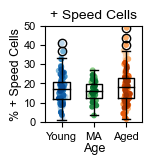

In [162]:
print(len(y_sind),len(ma_sind),len(age_sind))
#manuscript version
fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [sper99[y_sind99], sper99[ma_sind99], sper99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% + Speed Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
#plt.savefig(save_folder + 'age_speedcelldensity99_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_speedcelldensity99_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [65]:
''' Find where I will have NaNs due to 0% speed cells in a given Session'''
nan_idx99 = np.where((sper99 == 0))[0]
nan_idx1 = np.where((sper1 == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
ma_sind99 = np.setdiff1d(ma_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

y_sind1 = np.setdiff1d(y_sind, nan_idx1)
ma_sind1 = np.setdiff1d(ma_sind, nan_idx1)
age_sind1 = np.setdiff1d(age_sind, nan_idx1)

#adjust colormaps
yidx = []
maidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young99 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma99 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session99 = [col_session_young99, col_session_ma99, col_session_old99] 

yidx = []
maidx = []
aidx = []
for i in nan_idx1:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young1 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma1 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old1 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session1 = [col_session_young1, col_session_ma1, col_session_old1]       

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

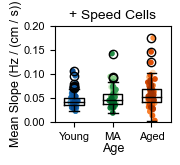

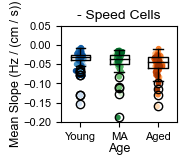

In [68]:
''' Plot Figure 6d '''

#set up handles
from itertools import repeat
handles = []
mper = [mper1[y_ind], mper1[ma_ind], mper1[age_ind]]

for i in range(len(mper)):    
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))
               
#Plot Figure 6d (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope99[y_sind99], sslope99[ma_sind99], sslope99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
#plt.savefig(save_folder + 'age_speedcellslope99_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_speedcellslope99_session.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure 6d (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope1[y_sind1], sslope1[ma_sind1], sslope1[age_sind1]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session1[i], edgecolors = col_session1[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.2,0.05])
ax.set_yticks([-0.2,-0.15,-0.1,-0.05,0, 0.05])
#plt.savefig(save_folder + 'age_speedcellslope1_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_speedcellslope1_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [69]:
''' Statistics for Figure 6d (left) '''
print('\nn young, MA, sessions with + speed cells:')
print(len(y_sind99),len(ma_sind99), len(age_sind99))

print('\nspeedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope99[ma_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[ma_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[age_sind99]), 4)))

stat, p_diff = stats.kruskal(sslope99[y_sind99],sslope99[ma_sind99],sslope99[age_sind99])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#get what you need for multiple comparisons
import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind99,ma_sind99,age_sind99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopepos = list(sslope99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopepos', group_col = 'AgeGroup', p_adjust = 'holm')


speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
0.0445 ± 0.0015 ; 0.0508 ± 0.0027 ; 0.0556 ± 0.0026
stat = 15.152660049457381
p_session = 0.0005124384125900913


,1.0,2.0,3.0
1.0,1.000000,0.111112,0.000256
2.0,0.111112,1.000000,0.123937
3.0,0.000256,0.123937,1.000000


In [70]:
''' Statistics for Figure 6d (right) '''
print('\nn young, MA, sessions with - speed cells:')
print(len(y_sind1),len(ma_sind1), len(age_sind1))

print('speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope1[y_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[y_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope1[ma_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[ma_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope1[age_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[age_sind1]), 4)))

stat, p_diff = stats.kruskal(sslope1[y_sind1],sslope1[ma_sind1],sslope1[age_sind1])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind1,ma_sind1,age_sind1))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope1[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg',])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopeneg', group_col = 'AgeGroup', p_adjust = 'holm')

speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
-0.0366 ± 0.0024 ; -0.0432 ± 0.004 ; -0.05 ± 0.0026
stat = 24.32554182335332
p_session = 5.221264668905101e-06


,1.0,2.0,3.0
1.0,1.000000,0.081584,0.000002
2.0,0.081584,1.000000,0.013550
3.0,0.000002,0.013550,1.000000


In [72]:
''' Collect Speed Cell Trial Stability Score 

Run time: 10-15 seconds / session x 250 sessions with either type of speed cell.

'''
# set up arrays for plotting by session 
strialstabscore1 = []
strialstabscore99 = []

dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(save_folder + A_file)
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        #get spike-weighted average of speed score by trial for each speed cell population
        bytrialspeedstabilityscores99 = []          
        for i, c in enumerate(speedcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            bytrialspeedstabilityscores99 = np.append(bytrialspeedstabilityscores99, np.nansum(weightscore) / np.sum(A[:,sdx]))
            
        bytrialspeedstabilityscores1 = []
        for i, c in enumerate(speedcells1):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))
        
            bytrialspeedstabilityscores1 = np.append(bytrialspeedstabilityscores1, np.nansum(weightscore) / np.sum(A[:,sdx]))

        strialstabscore99 = np.append(strialstabscore99, np.mean(bytrialspeedstabilityscores99))
        strialstabscore1 = np.append(strialstabscore1, np.mean(bytrialspeedstabilityscores1))

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

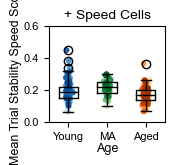

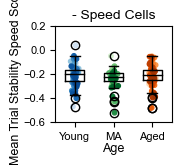

In [73]:
''' Plot Figure 6E '''

#Figure 6E (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore99[y_sind99], strialstabscore99[ma_sind99], strialstabscore99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.6])
ax.set_yticks([0,0.2,0.4,0.6])
#plt.savefig(save_folder + 'age_speedcell99trialstabscore_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_speedcell99trialstabscore_session.svg', dpi=400, bbox_inches='tight')
plt.show()

#Figure 6E (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore1[y_sind1], strialstabscore1[ma_sind1], strialstabscore1[age_sind1]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session1[i], edgecolors = col_session1[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.6,0.2])
ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2])
#plt.savefig(save_folder + 'age_speedcell1trialstabscore_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_speedcell1trialstabscore_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [76]:
''' Stats for Figure 6e (left)'''

print('\nPOS SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore99[ma_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[ma_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[age_sind99]), 4)))

stat, p_diff = stats.kruskal(strialstabscore99[y_sind99],strialstabscore99[ma_sind99],strialstabscore99[age_sind99])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#POSTIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind99,ma_sind99,age_sind99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scorepos = list(strialstabscore99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scorepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scorepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scorepos', group_col = 'AgeGroup', p_adjust = 'holm')



POS SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
0.1905 ± 0.0063 ; 0.2143 ± 0.0061 ; 0.1693 ± 0.0047
stat = 29.4836321610112
p_trialstabscore = 3.960140761439548e-07


,1.0,2.0,3.0
1.0,1.000000,7.961169e-04,1.308860e-02
2.0,0.000796,1.000000e+00,7.481447e-08
3.0,0.013089,7.481447e-08,1.000000e+00


In [77]:
''' Stats for Figure 6e (right)'''

print('\nNEG SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore1[y_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[y_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore1[ma_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[ma_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore1[age_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[age_sind1]), 4)))

stat, p_diff = stats.kruskal(strialstabscore1[y_sind1],strialstabscore1[ma_sind1],strialstabscore1[age_sind1])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind1,ma_sind1,age_sind1))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore1[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scoreneg'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scoreneg', group_col = 'AgeGroup', p_adjust = 'holm')


NEG SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
-0.2125 ± 0.0081 ; -0.2393 ± 0.0098 ; -0.2165 ± 0.0082
stat = 6.4131184926557125
p_trialstabscore = 0.040495709598212117


,1.0,2.0,3.0
1.0,1.000000,0.040830,0.592191
2.0,0.040830,1.000000,0.091193
3.0,0.592191,0.091193,1.000000


# Examine grid scale gradients in MEC

In [118]:
'''Define which mice & sessions to load based on metadata'''

#note that here we are loading in all sessions that have dark data and distance-tuning shuffle scores 
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [119]:
''' From session metadata, get max depth of probe tip'''

for m, session in zip(mice,sessions):
    seshcount = 1
    for s in session:
        d = data[m][s]
        
        #define LFP folder
        MECmaxdepth = np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'Final Depth (D)'])[0]
        d['MECmaxdepth'] = MECmaxdepth
        
        seshcount += 1

In [120]:
''' Load in grid cell IDs for Split Maze Sessions (previously generated)'''
save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/' #adjust to output of Figure 2/S3 notebook
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #output of import/filter notebook

for m, session in zip(mice,sessions):

    for s in session:
        d = data[m][s]
        
        #load Split Maze grid cell boolean from Figure 2/S3 Notebook output
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(save_folder + gridcell_file)
        gridcell = gridcell.astype(bool)
        d['gridcell'] = gridcell

# Estimate grid scale, calculate depth along the probe relative to brain surface among classified grid cells, and plot Figure 6F OR skip to next section

In [ ]:
''' Calculate each grid cell's depth from surface and estimated grid scale; plot panels of Figure 6f '''

#parameters 
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20
lag_max = 800
lags = np.arange(0,801,1)
n_dark = 20 #trials

ex_mice = ['Y21','MA9F','A15']
ex_sessions = ['091822_record1','111522_record3','090122_record3']

#adjust paths 
dataload_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #output of import/filter notebook
load_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/' #output of shuffle notebook
plotsave_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/prefdist/' #wherever you want to save results of this

#arrays to save data
aprefdist = []
maprefdist = []
yprefdist = []
aaspikedepth = []
maaspikedepth = []
yaspikedepth = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(dataload_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        behaviorfil = np.load(dataload_folder + behavior_file, allow_pickle=False)
        Y = np.load(dataload_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
            
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        #call in data needed to calculate spike depths for each cell based on templates
        sp = raw.item().get('sp')
        temps = sp['temps'].copy() #nTemplates x nTimepoints x nChannels
        winv = sp['winv'].copy() #nCh x nCh
        ycoords = sp['ycoords'].copy() #nCh
        templates = sp['spikeTemplates'].copy() #nSpikes
        cluster_id = sp['clu'].copy() #nSpikes

        #Get spike depths
        spikeDepths = get_spike_depths(temps, winv, ycoords, templates) #distance from tip (lower = more ventral)

        gridcelldepths = []
        for i, c in enumerate(gridcells):
            gridcelldepths = np.append(gridcelldepths, np.median(spikeDepths[cluster_id == c]))
        d['gridcelldepths'] = gridcelldepths

        #load in maximal depth from surface of probe tip from session metadata
        MECmaxdepth = d['MECmaxdepth']
        adjgridcelldepths = MECmaxdepth - gridcelldepths
        d['adjgridcelldepths'] = adjgridcelldepths 

        ##Get preferred distance for each grid cell based on dark autocorrelation
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, b, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        prefdist = [] #stored lag of max peak
        norm_auto = np.zeros([gridcells.shape[0],lags.shape[0]]) #for plotting
        for i, c in enumerate(gridcells):
            sdx = np.where(cell_IDs == c)[0][0]

            autocorrelation = autocorr(FR[sdx,:], lags)
            normauto = ((autocorrelation - np.min(autocorrelation)) / (np.max(autocorrelation) - np.min(autocorrelation)))
            norm_auto[i,:] = normauto
            peaks, _ = find_peaks(normauto, width = 8, height = 0.05, prominence = 0.05)
            prefdist = np.append(prefdist, peaks[0])

        #save estimated grid scale into data dictionary 
        d['prefdist'] = prefdist 
        
        #save data & set color for example plots
        if m in SM_aged_mice:
            aprefdist = np.append(aprefdist,prefdist)
            aaspikedepth = np.append(aaspikedepth, adjgridcelldepths)
            col = 'C1'
        elif m in SM_MA_mice:
            maprefdist = np.append(maprefdist,prefdist)
            maaspikedepth = np.append(maaspikedepth, adjgridcelldepths)
            col = 'C2'
        elif m in SM_young_mice:
            yprefdist = np.append(yprefdist,prefdist)
            yaspikedepth = np.append(yaspikedepth, adjgridcelldepths)
            col = 'C0'   

        # if this is an example session, plot panel of Figure 6F
        if (m in ex_mice) and (s in ex_sessions):

            #sort norm auto inversely by spike depth
            sort_idx = np.argsort(gridcelldepths)

            sortnorm_auto = np.zeros([gridcells.shape[0],lags.shape[0]])
            for i in range(0,sortnorm_auto.shape[0]):
                sortnorm_auto[i,:] = norm_auto[sort_idx[i],:]

            #plot session grid cell dark FR autocorrelation heatmaps,  sorted by inversely by spike depth
            fig, ax = plt.subplots()
            fig.set_size_inches(2,3)
            ax.imshow(sortnorm_auto, clim = [0, 0.4], cmap='summer')
            ax.set_xticks(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_xticklabels(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_title(str(m) + '_' + str(s[-1]), fontsize=10, pad=5, color = col)
            ax.set_xlabel('Lag (cm)', fontsize=9, labelpad=1)
            ax.set_ylabel('Grid Cell (Ventral to Dorsal)', fontsize=9, labelpad=1)
            ax.tick_params(which='major', labelsize=8, pad=0.5)
            im = ax.imshow(sortnorm_auto, clim=[0, 0.4], aspect='auto', cmap='summer')
            cbar = fig.colorbar(im)
            cbar.ax.tick_params(labelsize = 8)
            #fig.savefig(plotsave_folder + m + '_' + s + '_gridautocorrdark.png', dpi=400, bbox_inches='tight')
            #fig.savefig(plotsave_folder + m + '_' + s + '_gridautocorrdark.svg', dpi=400, bbox_inches='tight')
            plt.show()

In [ ]:
'''Save Out Info if Calculated for the first time above'''

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]      
        
        prefdist = d['prefdist']
        prefdist_file = 'prefdist_' + str(m) + '_' + str(s) + '.npy'
        np.save(plotsave_folder + prefdist_file, prefdist)
        
        gridcelldepths = d['gridcelldepths']
        depths_file = 'depths_' + str(m) + '_' + str(s) + '.npy'
        np.save(plotsave_folder + depths_file, gridcelldepths)

# Load estimated grid scale & depth if previously calculated & plot Figure 6F

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

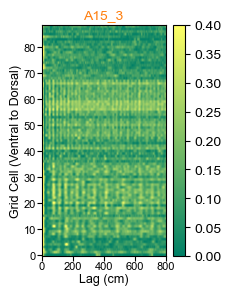

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

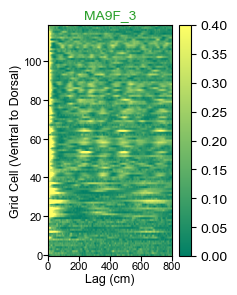

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

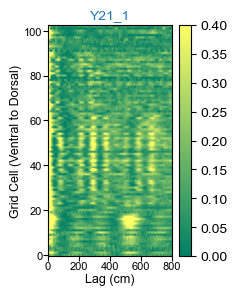

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [160]:
''' Calculate each grid cell's depth from surface and estimated grid scale; plot panels of Figure 6f '''

#parameters 
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20
lag_max = 800
lags = np.arange(0,801,1)
n_dark = 20 #trials

ex_mice = ['Y21','MA9F','A15']
ex_sessions = ['091822_record1','111522_record3','090122_record3']

#adjust paths 
dataload_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #output of import/filter notebook
load_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/' #output of shuffle notebook
plotsave_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/prefdist/' #wherever you want to save results of this

#arrays to save data
aprefdist = []
maprefdist = []
yprefdist = []
aaspikedepth = []
maaspikedepth = []
yaspikedepth = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(dataload_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        behaviorfil = np.load(dataload_folder + behavior_file, allow_pickle=False)
        Y = np.load(dataload_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
                
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell] 
        
        #load estimated grid scales & unit depths
        prefdist_file = 'prefdist_' + str(m) + '_' + str(s) + '.npy'
        d['prefdist'] = np.load(plotsave_folder + prefdist_file)
        prefdist = d['prefdist']

        depths_file = 'depths_' + str(m) + '_' + str(s) + '.npy'
        d['gridcelldepths'] = np.load(plotsave_folder + depths_file)
        gridcelldepths = d['gridcelldepths']
        
        #adjust depth to be relative to brain surface along probe using session metadata
        MECmaxdepth = d['MECmaxdepth']
        adjgridcelldepths = MECmaxdepth - gridcelldepths
        d['adjgridcelldepths'] = adjgridcelldepths 
        
        #save data & set color for example plots
        if m in SM_aged_mice:
            aprefdist = np.append(aprefdist,prefdist)
            aaspikedepth = np.append(aaspikedepth, adjgridcelldepths)
            col = 'C1'
        elif m in SM_MA_mice:
            maprefdist = np.append(maprefdist,prefdist)
            maaspikedepth = np.append(maaspikedepth, adjgridcelldepths)
            col = 'C2'
        elif m in SM_young_mice:
            yprefdist = np.append(yprefdist,prefdist)
            yaspikedepth = np.append(yaspikedepth, adjgridcelldepths)
            col = 'C0'   

        # if this is an example session, plot panel of Figure 6F
        if ((m in ex_mice) and (s in ex_sessions)):
            
            ##Get preferred distance for each grid cell based on dark autocorrelation
            #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
            FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, b, smooth=True, normalize=True, occupancy=True)
            stop_idx = np.where(trials == n_dark)[0][0]
            FR = FR[:stop_idx,:,:]
            n_trials = FR.shape[0]
            n_pos = FR.shape[1]
            n_cells = FR.shape[2]
            FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

            #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
            norm_auto = np.zeros([gridcells.shape[0],lags.shape[0]]) #for plotting
            
            for i, c in enumerate(gridcells):
                sdx = np.where(cell_IDs == c)[0][0]

                autocorrelation = autocorr(FR[sdx,:], lags)
                normauto = ((autocorrelation - np.min(autocorrelation)) / (np.max(autocorrelation) - np.min(autocorrelation)))
                norm_auto[i,:] = normauto

                #sort norm auto inversely by spike depth
                sort_idx = np.argsort(gridcelldepths)

                sortnorm_auto = np.zeros([gridcells.shape[0],lags.shape[0]])
                for i in range(0,sortnorm_auto.shape[0]):
                    sortnorm_auto[i,:] = norm_auto[sort_idx[i],:]

            #plot session grid cell dark FR autocorrelation heatmaps,  sorted by inversely by spike depth
            fig, ax = plt.subplots()
            fig.set_size_inches(2,3)
            ax.imshow(sortnorm_auto, clim = [0, 0.4], cmap='summer')
            ax.set_xticks(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_xticklabels(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_title(str(m) + '_' + str(s[-1]), fontsize=10, pad=5, color = col)
            ax.set_xlabel('Lag (cm)', fontsize=9, labelpad=1)
            ax.set_ylabel('Grid Cell (Ventral to Dorsal)', fontsize=9, labelpad=1)
            ax.tick_params(which='major', labelsize=8, pad=0.5)
            im = ax.imshow(sortnorm_auto, clim=[0, 0.4], aspect='auto', cmap='summer')
            cbar = fig.colorbar(im)
            #cbar.ax.tick_params(labelsize = 8)
            fig.savefig(plotsave_folder + m + '_' + s + '_gridautocorrdark.png', dpi=400, bbox_inches='tight')
            fig.savefig(plotsave_folder + m + '_' + s + '_gridautocorrdark.svg', dpi=400, bbox_inches='tight')
            plt.show()

# Compare grid scale distributions across age groups (Figures 6G-J)

In [125]:
'''Report Number of Grid Cells in each Age Group'''

print('n grid cells young, MA, aged: ')
print(len(yprefdist), len(maprefdist), len(aprefdist))

n grid cells young, MA, aged: 
2441 2035 2032


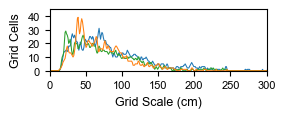

In [126]:
''' Plot Histograms of Grid Cell Preferred Distance (Figure 6G) '''
lagbins = np.arange(0,801,1)
fig, ax = plt.subplots(figsize = (2.8,0.8))

y, bin_edges = np.histogram(yprefdist, bins = lagbins)
y = gaussian_filter1d(y, sigma = 1)
bincenters = 0.5 *(bin_edges[1:] + bin_edges[:-1])
ax.plot(bincenters, y, '-', linewidth = 0.75, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(maprefdist, bins = lagbins)
ma = gaussian_filter1d(ma, sigma = 1)
bincenters = 0.5 *(bin_edges[1:] + bin_edges[:-1])
ax.plot(bincenters, ma, '-', linewidth = 0.75, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(aprefdist, bins = lagbins)
a = gaussian_filter1d(a, sigma = 1)
bincenters = 0.5 *(bin_edges[1:] + bin_edges[:-1])
ax.plot(bincenters, a, '-', linewidth = 0.75, color = 'C1', label = 'Aged')

#plt.title('Grid Cell Pref Dist by Age Group', fontsize = 10)
plt.ylabel('Grid Cells', fontsize = 9)
plt.xlabel('Grid Scale (cm)', fontsize = 9)
ax.set_xlim(0,300)
ax.set_ylim(0,45)
ax.set_yticks([0,10,20,30,40])
ax.tick_params(labelsize = 8)
#plt.legend()
#plt.savefig(plotsave_folder + 'allgridcellprefdist.png', dpi=400, bbox_inches='tight')
#plt.savefig(plotsave_folder + 'allgridcellprefdist.svg', dpi=400, bbox_inches='tight')
plt.show()

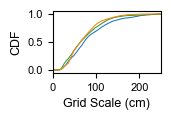

In [127]:
''' Plot 6h (left)'''

lagbins = np.arange(0,801,1)
#fig, ax = plt.subplots(figsize = (8,2))
fig, ax = plt.subplots(figsize = (1.4,0.8))

y, bin_edges = np.histogram(yprefdist, bins = lagbins)
y = gaussian_filter1d(y, sigma = 1)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax.plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(maprefdist, bins = lagbins)
ma = gaussian_filter1d(ma, sigma = 1)
pdf = ma / sum(ma)
cdfma = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfma, '-', linewidth = 0.75, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(aprefdist, bins = lagbins)
a = gaussian_filter1d(a, sigma = 1)
pdf = a / sum(a)
cdfa = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfa, '-', linewidth = 0.75, color = 'C1', label = 'Aged')

#plt.title('Grid Scale', fontsize = 10)
plt.ylabel('CDF', fontsize = 9)
plt.xlabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax.set_yticks([0,0.5,1.0])
plt.xlim([0,250])
#plt.savefig(plotsave_folder + 'allgridcellprefdistcdf.png', dpi=400, bbox_inches='tight')
#plt.savefig(plotsave_folder + 'allgridcellprefdistcdf.svg', dpi=400, bbox_inches='tight')
plt.show()

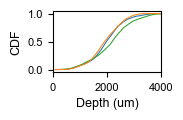

In [128]:
''' Plot 6h (right) '''
depthbins = np.arange(0,4500,100)
#fig, ax = plt.subplots(figsize = (8,2))
fig, ax = plt.subplots(figsize = (1.4,0.8))

y, bin_edges = np.histogram(yaspikedepth, bins = depthbins)
#y = gaussian_filter1d(y, sigma = 1)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax.plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(maaspikedepth, bins = depthbins)
#ma = gaussian_filter1d(ma, sigma = 1)
pdf = ma / sum(ma)
cdfma = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfma, '-', linewidth = 0.75, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(aaspikedepth, bins = depthbins)
#a = gaussian_filter1d(a, sigma = 1)
pdf = a / sum(a)
cdfa = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfa, '-', linewidth = 0.75, color = 'C1', label = 'Aged')

plt.ylabel('CDF', fontsize = 9)
plt.xlabel('Depth (um)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax.set_yticks([0,0.5,1.0])
plt.xlim([0,4000])
#plt.legend()
#plt.savefig(plotsave_folder + 'allgridcellMECdistcdf.png', dpi=400, bbox_inches='tight')
#plt.savefig(plotsave_folder + 'allgridcellMECdistcdf.svg', dpi=400, bbox_inches='tight')
plt.show()

In [152]:
''' Statistics for Grid Cell Depth & Scale'''

print('\nGRID CELL SCALE DIFFERENCES RESULTS KS:')
res = stats.ks_2samp(aprefdist,yprefdist, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(maprefdist,yprefdist, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('MA vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(aprefdist,maprefdist, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. MA CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

print('\nGRID CELL DEPTH RESULTS KS:')
res = stats.ks_2samp(aaspikedepth,yaspikedepth, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(maaspikedepth,yaspikedepth, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('MA vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(aaspikedepth,maaspikedepth, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. MA CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))


GRID CELL SCALE DIFFERENCES RESULTS KS:
A vs. Y CDF: Stat 0.11816608173363827, p=5.999841443610253e-14, sign=1, loc=100.0
MA vs. Y CDF: Stat 0.08537987915292299, p=1.7159836321005622e-07, sign=1, loc=54.0
A vs. MA CDF: Stat 0.07599368337557313, p=1.4597267925198267e-05, sign=-1, loc=35.0

GRID CELL DEPTH RESULTS KS:
A vs. Y CDF: Stat 0.05705697774566381, p=0.0013888506389229897, sign=1, loc=1795.0792663712589
MA vs. Y CDF: Stat 0.1440624789252401, p=1.489353821564416e-20, sign=-1, loc=2138.3676292767577
A vs. MA CDF: Stat 0.18273520478244887, p=3.5347856818413605e-30, sign=1, loc=2105.64946725254


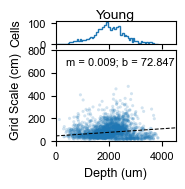

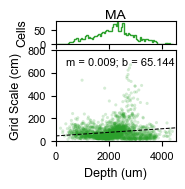

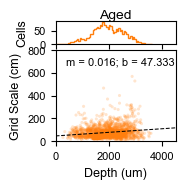

In [147]:
''' Plot Scatter Plots of Pref Dist vs. Distance from Surface Sampling by Age Groups (Figure 6I) '''

#define plotting function for vertically stacked histogram 
def scatter_histx(x, y, ax, ax_histx, col, sz = 5):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom = False)

    # the scatter plot:
    ax.scatter(x, y, s = sz, color = col, alpha = 0.2, edgecolor = 'None')

    # now determine nice limits by hand:
    binwidth = 50
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-2000, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, orientation='vertical', histtype = 'step', color = col)


#get some linear fits:
aslope, ayint, ar, _, _  = stats.linregress(aaspikedepth, aprefdist)
maslope, mayint, mar, _, _  = stats.linregress(maaspikedepth, maprefdist)
yslope, yyint, yr, _, _  = stats.linregress(yaspikedepth, yprefdist)

#Plot 6I (left)
fig = plt.figure(figsize=(1.5, 1.5))
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
scatter_histx(yaspikedepth, yprefdist, ax, ax_histx, col = 'C0', sz = 5)
ax.set_xlim([0,4500])
ax.set_ylim([0,800])
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope*X_plot + ayint, '--', color = 'k', linewidth = 0.75)
ax.set_xlabel('Depth (um)', fontsize = 9)
ax.set_ylabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax_histx.tick_params(labelsize = 8)
ax_histx.set_ylabel('Cells', fontsize = 9)
plt.text(400, -100, 'm = ' + str(np.round(yslope, 3)) + '; b = ' + str(np.round(yyint, 3)), fontsize = 8)
fig.suptitle('Young', fontsize = 10)
#plt.savefig(plotsave_folder + 'youngprefvsurfacedist.png', dpi=400, bbox_inches='tight')
#plt.savefig(plotsave_folder + 'youngprefvsurfacedist.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot 6I (middle)
fig = plt.figure(figsize=(1.5, 1.5))
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
scatter_histx(maaspikedepth, maprefdist, ax, ax_histx, col = 'C2', sz = 5)
ax.set_xlim([0,4500])
ax.set_ylim([0,800])
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope*X_plot + ayint, '--', color = 'k', linewidth = 0.75)
ax.set_xlabel('Depth (um)', fontsize = 9)
ax.set_ylabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax_histx.tick_params(labelsize = 8)
ax_histx.set_ylabel('Cells', fontsize = 9)
plt.text(400, -75, 'm = ' + str(np.round(maslope, 3)) + '; b = ' + str(np.round(mayint, 3)), fontsize = 8)
fig.suptitle('MA', fontsize = 10)
#plt.savefig(plotsave_folder + 'MAprefvsurfacedist.png', dpi=400, bbox_inches='tight')
#plt.savefig(plotsave_folder + 'MAprefvsurfacedist.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot 6I (right)
fig = plt.figure(figsize=(1.5, 1.5))
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
scatter_histx(aaspikedepth, aprefdist, ax, ax_histx, col = 'C1', sz = 5)
ax.set_xlim([0,4500])
ax.set_ylim([0,800])
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope*X_plot + ayint, '--', color = 'k', linewidth = 0.75)
ax.set_xlabel('Depth (um)', fontsize = 9)
ax.set_ylabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
plt.text(400, -75, 'm = ' + str(np.round(aslope, 3)) + '; b = ' + str(np.round(ayint, 3)), fontsize = 8)
fig.suptitle('Aged', fontsize = 10)
ax_histx.tick_params(labelsize = 8)
ax_histx.set_ylabel('Cells', fontsize = 9)
#plt.savefig(plotsave_folder + 'agedprefvsurfacedist.png', dpi=400, bbox_inches='tight')
#plt.savefig(plotsave_folder + 'agedprefvsurfacedist.svg', dpi=400, bbox_inches='tight')
plt.show()

In [131]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
alldists = []
alldepths = []
alladjdepths = []
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(dataload_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        prefdist = d['prefdist']
        alldists = np.append(alldists, prefdist)
        
        depths = d['gridcelldepths']
        alldepths = np.append(alldepths, depths)
        
        adjdepths = d['adjgridcelldepths']
        alladjdepths = np.append(alladjdepths, adjdepths)
        
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Cohort = list(ccohort)
Age_Group = list(cage)
Cell_ID = list(cidx)
        
#gather dependent variables into lists
Dists = list(alldists)
Depths = list(alldepths)
Adjdepths = list(alladjdepths)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Dists      
No. Observations:       6508          Method:                   REML       
No. Groups:             29            Scale:                    1332.1182  
Min. group size:        60            Log-Likelihood:           -35727.5711
Max. group size:        446           Converged:                Yes        
Mean group size:        224.4                                              
---------------------------------------------------------------------------
                              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                      76.026    8.521  8.922 0.000  59.326  92.727
C(AgeGroup)[T.2.0]             -3.766   12.702 -0.297 0.767 -28.662  21.129
C(AgeGroup)[T.3.0]            -32.439   10.804 -3.002 0.003 -53.614 -11.263
C(Cohort)[T.D]                 

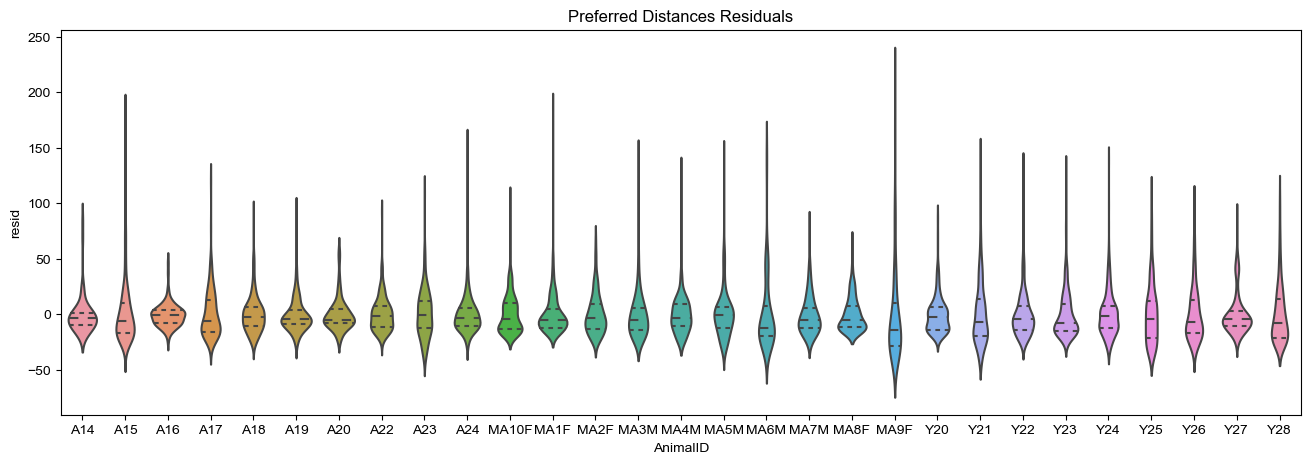

In [158]:
''' LMM for Grid Scale '''

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Cohort, Age_Group, Dists, Depths, Adjdepths))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'Cohort', 'AgeGroup','Dists','Depths','Adjdepths'])

#handle NaNs
df = df.dropna()

# Dist Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mdist = smf.mixedlm('Dists ~ 1 + C(AgeGroup) + C(Cohort) + C(Sex) + Adjdepths + Adjdepths:C(AgeGroup) + Session', groups = 'AnimalID', re_formula = '1', vc_formula = vc, data=df).fit(reml = True)
print(mdist.summary())
print(mdist.wald_test_terms(scalar = False))

#plots of residuals
df['resid'] = mdist.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Preferred Distances Residuals')
plt.show()

C:\Users\Python\AppData\Local\Temp\ipykernel_3780\1243058501.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = animalmeta, x = 'Age_Group', y = 'meangridscale', ax = ax, palette = pal, size = 5)


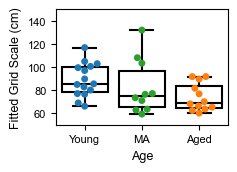

In [159]:
''' Plot LMM Fitted Mean Grid Scale by Animal (Figure 6j)'''

new_palette =  sns.color_palette(n_colors = 3)
new_palette[1], new_palette[2] = new_palette[2], new_palette[1]
df['gridscale'] = mdist.fittedvalues

animalgrouped = df.groupby('AnimalID')
animalscales = animalgrouped['gridscale'].mean()
scales = np.array(animalscales)
    
#save sorted output to animal metadata csv
for i, c in enumerate(scales):
    m = animalscales.index[i]
    animalmeta.loc[np.where(animalmeta.Animal_ID == str(m))[0][0], 'meangridscale'] = c
    
tab10 = sns.color_palette("tab10")
pal = {tab10[0],tab10[2],tab10[1]}

fig, ax = plt.subplots(figsize = (2.215,1.5))
sns.boxplot(data = animalmeta, x = 'Age_Group', y = 'meangridscale', ax = ax, boxprops = {'facecolor': 'none', 'edgecolor':'black'},
               medianprops = {'color': 'black'}, whiskerprops = {'color': 'black'}, capprops = {'color': 'black'}, dodge = False)
sns.swarmplot(data = animalmeta, x = 'Age_Group', y = 'meangridscale', ax = ax, palette = pal, size = 5)
ax.set_ylabel('Fitted Grid Scale (cm)', fontsize = 9)
ax.set_xlabel('Age', fontsize = 9)
ax.set_xticklabels(['Young','MA','Aged'])
ax.tick_params(labelsize = 8)
ax.set_ylim(50,150)
plt.savefig(plotsave_folder + 'LMM_fitted_avganimalscale.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(plotsave_folder + 'LMM_fitted_avganimalscale.svg', dpi = 400, bbox_inches = 'tight')
plt.show()